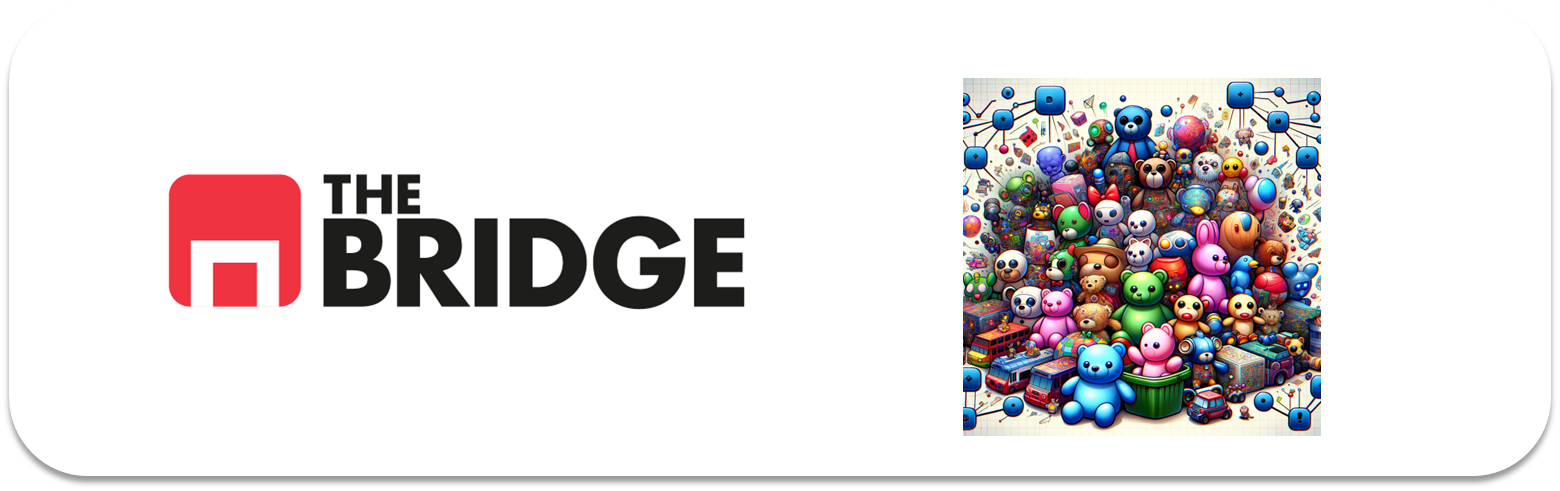

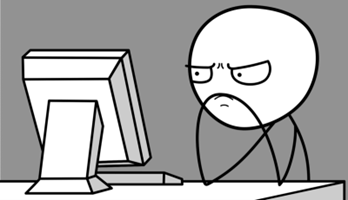

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

In [3]:
!pip install yellowbrick

In [17]:
# 📌 Importación de librerías necesarias
import pandas as pd  # Manipulación de datos
import numpy as np  # Operaciones numéricas
import matplotlib.pyplot as plt  # Visualización
import seaborn as sns  # Visualización avanzada
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Preprocesamiento de datos
from sklearn.cluster import KMeans  # Algoritmo de clustering K-Means
from sklearn.metrics import silhouette_score  # Evaluación del clustering
from scipy.spatial.distance import cdist  # Cálculo de distancias
from scipy.cluster.hierarchy import dendrogram, linkage  # Clustering jerárquico
from sklearn.decomposition import PCA  # Reducción de dimensionalidad
from sklearn.manifold import TSNE  # Reducción de dimensionalidad no lineal
from yellowbrick.cluster import KElbowVisualizer  # Visualización del método del codo

# Configuración de visualización
sns.set(style="whitegrid")  # Estilo de gráficos
plt.rcParams["figure.figsize"] = (10, 6)  # Tamaño de gráficos por defecto

print("📌 Todas las librerías han sido importadas correctamente.")


📌 Todas las librerías han sido importadas correctamente.


### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [ ]:
import pandas as pd

# Ruta del archivo (corrige la ruta si es necesario)
file_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_raw.tsv"

# Cargar el archivo TSV con tabulaciones como separador
df = pd.read_csv(file_path, sep="\t", encoding="utf-8")

# Inspección preliminar
print("🔍 Primeras filas del dataset:")
print(df.head())



🔍 Primeras filas del dataset:
   Unnamed: 0       urlDrugName  rating         effectiveness  \
0        2202         enalapril       4      Highly Effective   
1        3117  ortho-tri-cyclen       1      Highly Effective   
2        1146           ponstel      10      Highly Effective   
3        3947          prilosec       3  Marginally Effective   
4        1951            lyrica       2  Marginally Effective   

           sideEffects                               condition  \
0    Mild Side Effects  management of congestive heart failure   
1  Severe Side Effects                        birth prevention   
2      No Side Effects                        menstrual cramps   
3    Mild Side Effects                             acid reflux   
4  Severe Side Effects                            fibromyalgia   

                                      benefitsReview  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used 

### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [60]:


# Cargar el dataset desde la ruta correcta
file_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_raw.tsv"
df = pd.read_csv(file_path, sep="\t", encoding="utf-8")

# 🔍 Inspección preliminar de las columnas
print("📌 Nombres de las columnas del dataset:")
print(df.columns)

# 📊 Calcular la cardinalidad de cada columna
cardinalidad = df.nunique()
total_filas = df.shape[0]

# 📉 Calcular el porcentaje de cardinalidad
porcentaje_cardinalidad = (cardinalidad / total_filas) * 100

# 📊 Crear un DataFrame con la información de cardinalidad
df_cardinalidad = pd.DataFrame({
    "Columna": df.columns,
    "Cardinalidad": cardinalidad.values,
    "Porcentaje": porcentaje_cardinalidad.values
}).sort_values(by="Porcentaje", ascending=False)

# 📌 Mostrar la tabla con la cardinalidad
print("\n📊 Cardinalidad de las variables:")
print(df_cardinalidad)

# 🚀 Filtrar columnas a eliminar
columnas_a_descartar = df_cardinalidad[df_cardinalidad["Porcentaje"] > 80]["Columna"].tolist()  # Umbral del 80%
columnas_a_descartar.append("urlDrugName")  # Eliminamos la URL por simplificación

print(f"\n🛑 Columnas eliminadas: {columnas_a_descartar}")

# 🎯 Crear un nuevo dataset sin estas columnas
df_filtrado = df.drop(columns=columnas_a_descartar, errors="ignore")

# 🔍 Mostrar primeras filas del dataset filtrado
print("\n✅ Dataset después de la limpieza:")
print(df_filtrado.head())

# Guardar el dataset limpio para los siguientes ejercicios
df_filtrado.to_csv(r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_cleaned.csv", index=False)



📌 Nombres de las columnas del dataset:
Index(['Unnamed: 0', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects',
       'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'],
      dtype='object')

📊 Cardinalidad de las variables:
             Columna  Cardinalidad  Porcentaje
0         Unnamed: 0          3107  100.000000
8     commentsReview          3046   98.036691
6     benefitsReview          3031   97.553911
7  sideEffectsReview          2813   90.537496
5          condition          1426   45.896363
1        urlDrugName           502   16.157065
2             rating            10    0.321854
3      effectiveness             5    0.160927
4        sideEffects             5    0.160927

🛑 Columnas eliminadas: ['Unnamed: 0', 'commentsReview', 'benefitsReview', 'sideEffectsReview', 'urlDrugName']

✅ Dataset después de la limpieza:
   rating         effectiveness          sideEffects  \
0       4      Highly Effective    Mild Side Effects   
1       1      Highly

### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [57]:
# Definir las columnas seleccionadas (features que NO fueron descartadas)
columnas_seleccionadas = df_filtrado.columns.tolist()

# Crear el dataset de entrenamiento (X)
X = df_filtrado[columnas_seleccionadas].copy()

# 📌 Mostrar información del nuevo dataset de entrenamiento
print("✅ Train set creado correctamente.")
print(f"📊 Dimensiones de X: {X.shape}")
print(f"📌 Columnas seleccionadas en X: {columnas_seleccionadas}")

# Mostrar las primeras filas del dataset
print("\n🔍 Primeras filas de X:")
print(X.head())

# Guardar X para uso futuro
X.to_csv(r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_features.csv", index=False)


✅ Train set creado correctamente.
📊 Dimensiones de X: (3107, 5)
📌 Columnas seleccionadas en X: ['rating', 'effectiveness', 'sideEffects', 'condition', 'Cluster']

🔍 Primeras filas de X:
   rating         effectiveness          sideEffects  \
0       4      Highly Effective    Mild Side Effects   
1       1      Highly Effective  Severe Side Effects   
2      10      Highly Effective      No Side Effects   
3       3  Marginally Effective    Mild Side Effects   
4       2  Marginally Effective  Severe Side Effects   

                                condition  Cluster  
0  management of congestive heart failure        2  
1                        birth prevention        2  
2                        menstrual cramps        0  
3                             acid reflux        2  
4                            fibromyalgia        2  


### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [58]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 📌 Identificar columnas categóricas y numéricas
columnas_categoricas = X.select_dtypes(include=["object"]).columns.tolist()
columnas_numericas = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"📌 Columnas categóricas: {columnas_categoricas}")
print(f"📌 Columnas numéricas: {columnas_numericas}")

# 🔹 Definir transformaciones para cada tipo de dato
transformaciones = ColumnTransformer([
    ("num_scaler", StandardScaler(), columnas_numericas),  # Escalado de numéricas
    ("cat_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), columnas_categoricas)  # Codificación de categóricas
])

# 📌 Crear un pipeline de preprocesamiento
pipeline = Pipeline([
    ("transformaciones", transformaciones)
])

# 🚀 Aplicar el pipeline al dataset
X_transformado = pipeline.fit_transform(X)

# 📌 Convertir a DataFrame manteniendo nombres de columnas
columnas_codificadas = pipeline.named_steps["transformaciones"].named_transformers_["cat_encoder"].get_feature_names_out(columnas_categoricas)
columnas_finales = columnas_numericas + list(columnas_codificadas)
X_procesado = pd.DataFrame(X_transformado, columns=columnas_finales)

# 📊 Mostrar información del nuevo dataset procesado
print("✅ Transformación completada.")
print(f"📊 Dimensiones de X procesado: {X_procesado.shape}")
print("\n🔍 Primeras filas de X después de transformación:")
print(X_procesado.head())

# 📁 Guardar el dataset transformado para siguientes ejercicios
X_procesado.to_csv(r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_transformed.csv", index=False)


📌 Columnas categóricas: ['effectiveness', 'sideEffects', 'condition']
📌 Columnas numéricas: ['rating']
✅ Transformación completada.
📊 Dimensiones de X procesado: (3107, 1438)

🔍 Primeras filas de X después de transformación:
     rating  effectiveness_Considerably Effective  \
0 -1.023494                                   0.0   
1 -2.044907                                   0.0   
2  1.019330                                   0.0   
3 -1.363965                                   0.0   
4 -1.704436                                   0.0   

   effectiveness_Highly Effective  effectiveness_Ineffective  \
0                             1.0                        0.0   
1                             1.0                        0.0   
2                             1.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   

   effectiveness_Marginally Effective  effectiveness_Moderately Effecti

### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


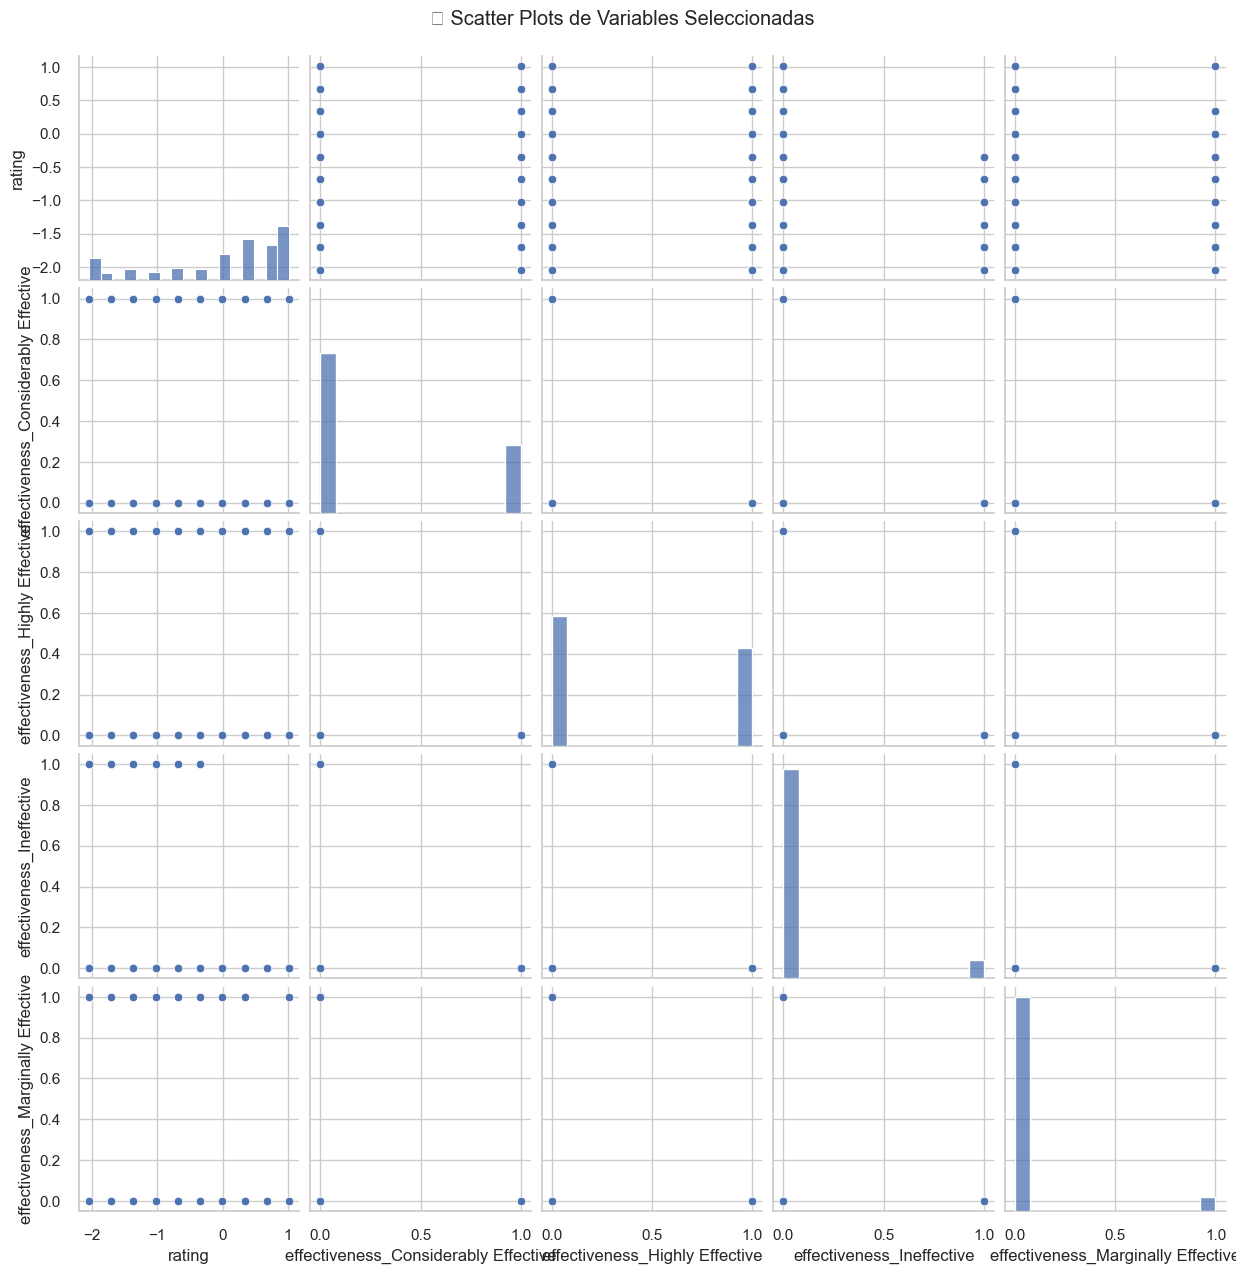

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


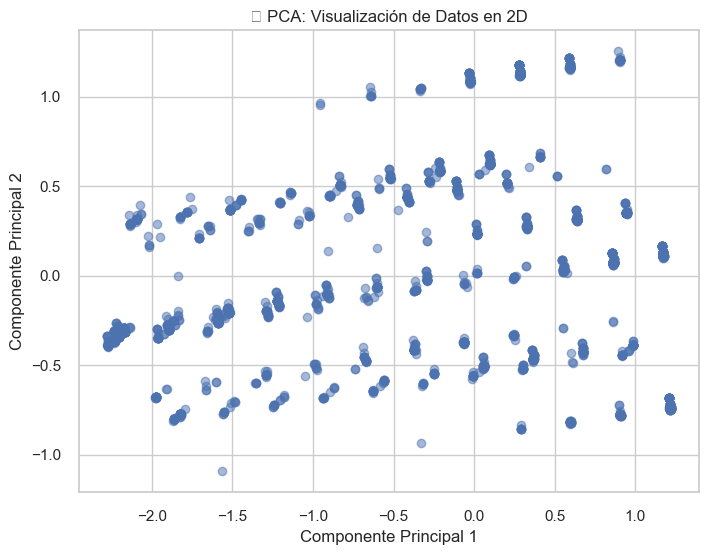

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


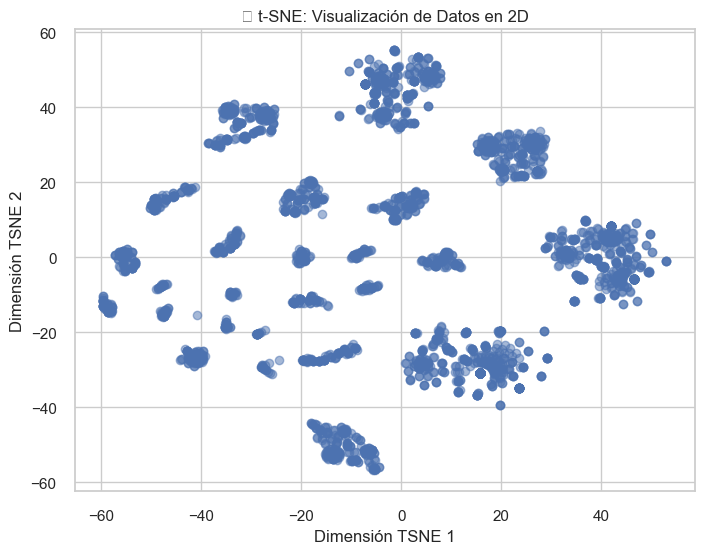

In [59]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 🔹 Selección de features numéricas para análisis visual
num_features = X_procesado.iloc[:, :5]  # Tomamos las primeras 5 columnas numéricas

# 📊 Crear scatter plots de pares de variables para buscar patrones
sns.pairplot(num_features)
plt.suptitle("🔍 Scatter Plots de Variables Seleccionadas", y=1.02)
plt.show()

# 🚀 **Reducción de dimensionalidad con PCA**
pca = PCA(n_components=2)  # Reducimos a 2 dimensiones
X_pca = pca.fit_transform(X_procesado)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("🔍 PCA: Visualización de Datos en 2D")
plt.show()

# 🚀 **Reducción de dimensionalidad con t-SNE**
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_procesado)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)
plt.xlabel("Dimensión TSNE 1")
plt.ylabel("Dimensión TSNE 2")
plt.title("🔍 t-SNE: Visualización de Datos en 2D")
plt.show()


### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


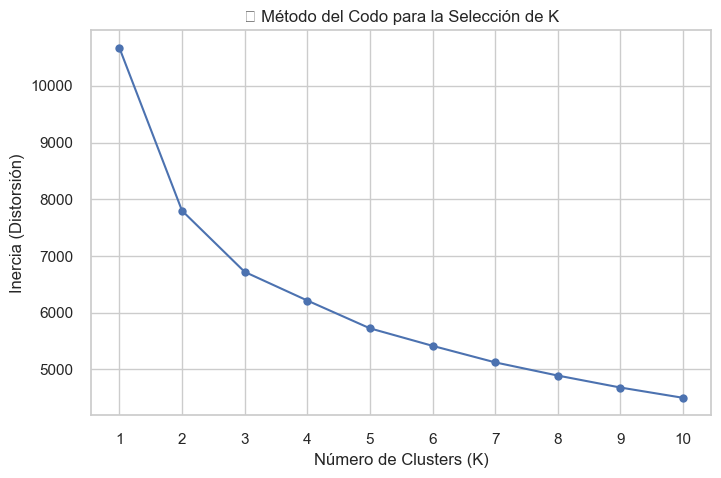

In [52]:


# 🔹 Definir un rango de valores de K a probar
k_values = range(1, 11)  # Probamos K desde 1 hasta 10
inertia_values = []

# 🚀 Aplicar K-Means para cada K y calcular la inercia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_procesado)  # X_procesado es el dataset ya transformado y escalado
    inertia_values.append(kmeans.inertia_)

# 📊 Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inercia (Distorsión)")
plt.title("🔍 Método del Codo para la Selección de K")
plt.xticks(k_values)
plt.grid(True)
plt.show()


### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


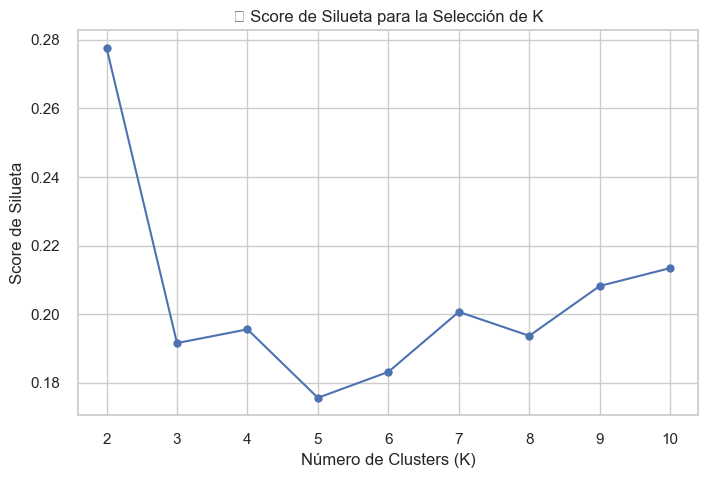

✅ El mejor número de clusters según el score de silueta es: 2


In [51]:


# 🔹 Definir el rango de K que analizamos en el método del codo
k_values = range(2, 11)  # Empezamos desde K=2 porque K=1 no tiene sentido para silueta
silhouette_scores = []

# 🚀 Aplicar K-Means y calcular el score de silueta para cada K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_procesado)  # X_procesado es el dataset transformado y escalado
    score = silhouette_score(X_procesado, cluster_labels)
    silhouette_scores.append(score)

# 📊 Graficar el score de silueta para cada K
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Score de Silueta")
plt.title("🔍 Score de Silueta para la Selección de K")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# 🏆 Encontrar el mejor K
best_k = k_values[np.argmax(silhouette_scores)]
print(f"✅ El mejor número de clusters según el score de silueta es: {best_k}")


### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


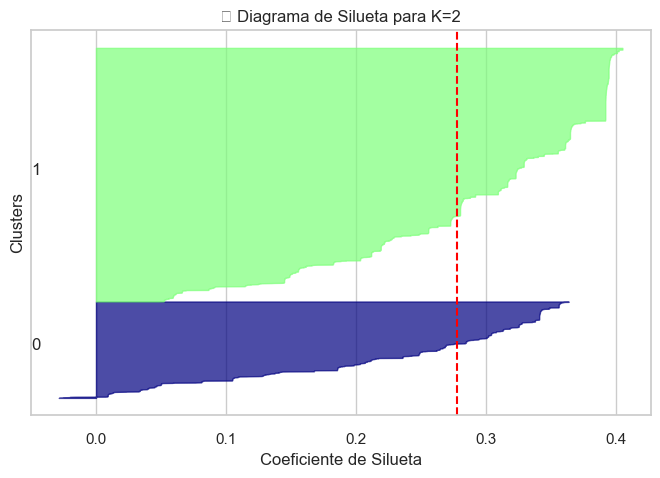

✅ Para K=2, el score de silueta promedio es: 0.2777


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


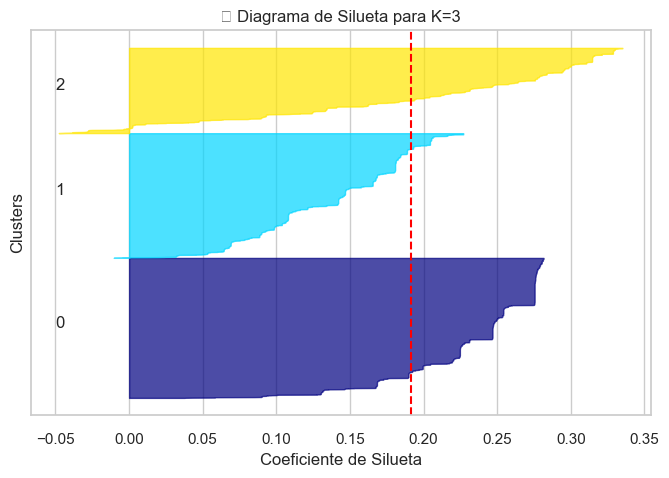

✅ Para K=3, el score de silueta promedio es: 0.1916


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


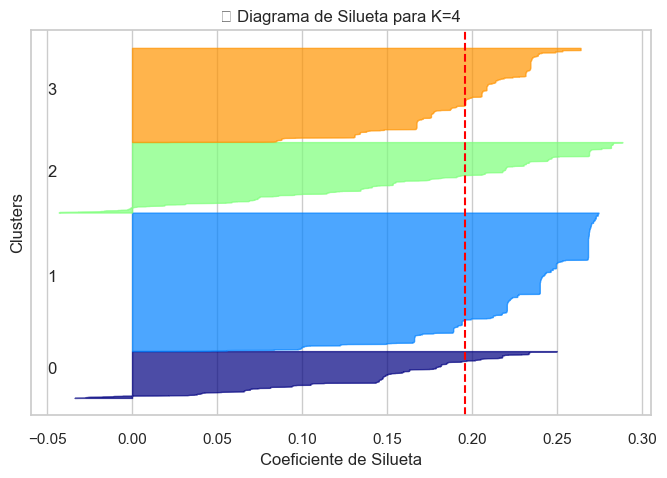

✅ Para K=4, el score de silueta promedio es: 0.1956


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


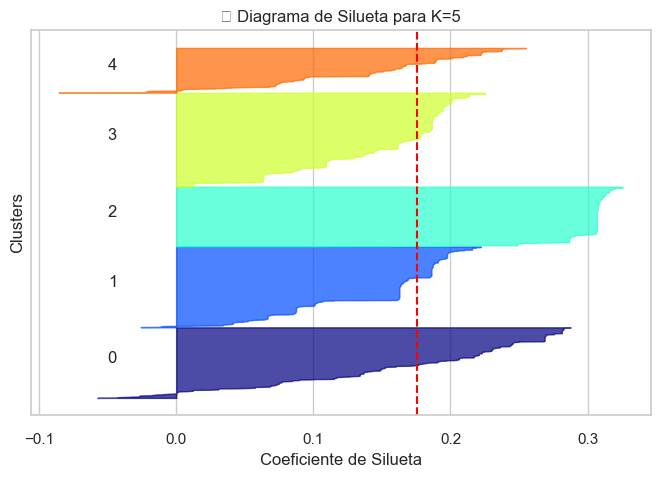

✅ Para K=5, el score de silueta promedio es: 0.1756


In [50]:


# 🔹 Definir valores de K a evaluar
k_values = [2, 3, 4, 5]

# 🚀 Iterar sobre cada K para generar el diagrama de silueta
for k in k_values:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # 📌 Aplicar K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_procesado)  # Dataset transformado y escalado
    
    # 📊 Calcular los valores de silueta para cada punto
    silhouette_vals = silhouette_samples(X_procesado, cluster_labels)
    
    y_lower, y_upper = 0, 0  # Límites de la visualización
    
    # 🔍 Dibujar cada cluster en la gráfica
    for i in range(k):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        
        color = cm.jet(float(i) / k)  # Asignar colores
        
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
        
        plt.text(-0.05, y_lower + len(cluster_silhouette_vals) / 2, str(i))  # Etiquetas de cluster
        y_lower = y_upper
    
    # 📌 Score de silueta general
    avg_silhouette = silhouette_score(X_procesado, cluster_labels)
    
    # 📊 Ajustes del gráfico
    plt.axvline(avg_silhouette, color="red", linestyle="--")  # Línea del score medio
    plt.title(f"🔍 Diagrama de Silueta para K={k}")
    plt.xlabel("Coeficiente de Silueta")
    plt.ylabel("Clusters")
    plt.yticks([])
    plt.show()

    print(f"✅ Para K={k}, el score de silueta promedio es: {avg_silhouette:.4f}")


### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

📌 Cantidad de elementos por cluster:
Cluster
0    1243
1    1107
2     757
Name: count, dtype: int64


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


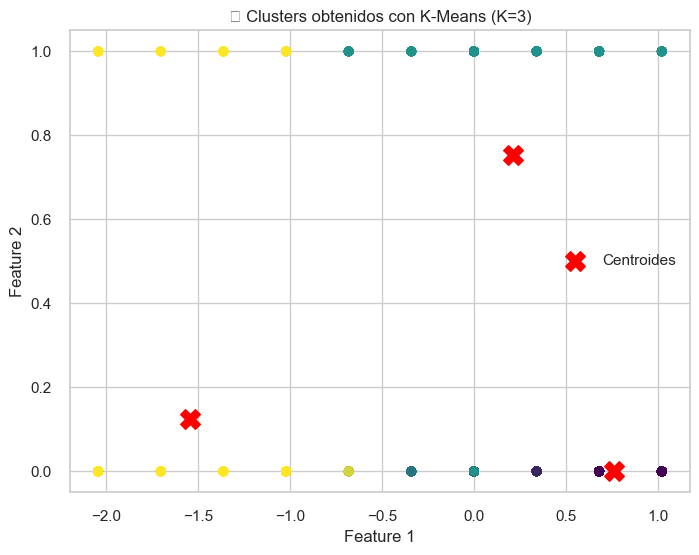

In [49]:


# 🔹 Definir el mejor valor de K basado en el análisis previo
k_optimo = 3  # 📌 Cambia este valor según tu análisis

# 🚀 Instanciar y entrenar el modelo K-Means
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_filtrado["Cluster"] = kmeans.fit_predict(X_procesado)  # Asignar clusters al dataset

# 📌 Cantidad de elementos por cluster
print("📌 Cantidad de elementos por cluster:")
print(df_filtrado["Cluster"].value_counts())

# 🎨 Visualización corregida
plt.figure(figsize=(8, 6))

# Asegurarnos de que X_procesado es un array numpy
if isinstance(X_procesado, pd.DataFrame):
    X_procesado = X_procesado.to_numpy()

plt.scatter(X_procesado[:, 0], X_procesado[:, 1], c=df_filtrado["Cluster"], cmap="viridis", alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="red", marker="X", s=200, label="Centroides")
plt.title(f"🔍 Clusters obtenidos con K-Means (K={k_optimo})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

In [48]:


# 📌 Cargar el dataset (ajusta la ruta según corresponda)
file_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_raw.tsv"
df = pd.read_csv(file_path, sep="\t", encoding="utf-8")

# 🔍 Verificar si la columna "Cluster" existe
if "Cluster" in df.columns:
    print("✅ La columna 'Cluster' ya está presente en el dataset.")
else:
    print("⚠️ La columna 'Cluster' no está en el dataset. Se procederá a asignar clústeres.")


⚠️ La columna 'Cluster' no está en el dataset. Se procederá a asignar clústeres.


In [30]:
print(df.dtypes)


Unnamed: 0            int64
urlDrugName          object
rating                int64
effectiveness        object
sideEffects          object
condition            object
benefitsReview       object
sideEffectsReview    object
commentsReview       object
dtype: object


In [31]:
from sklearn.preprocessing import LabelEncoder

# Crear un codificador
label_encoder = LabelEncoder()

# Convertir la columna categórica a valores numéricos
df["effectiveness_encoded"] = label_encoder.fit_transform(df["effectiveness"])

# Seleccionar solo las columnas numéricas para clustering
features = ["rating", "effectiveness_encoded"]  # Usamos la nueva columna numérica
X = df[features]


In [32]:
from sklearn.cluster import KMeans

# 🔹 Aplicar K-Means con el número óptimo de clusters (ajusta si es necesario)
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

# 🔥 Guardar el dataset con los clústeres asignados
df.to_csv(r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_clusters.tsv", sep="\t", index=False)

print("✅ Clústeres asignados y dataset guardado correctamente.")


✅ Clústeres asignados y dataset guardado correctamente.


📊 Resumen estadístico por cluster:
        Unnamed: 0                                                           \
             count         mean          std   min      25%     50%     75%   
Cluster                                                                       
0           2008.0  2042.674801  1186.350692   0.0  1033.75  2035.5  3060.5   
1            591.0  2196.744501  1193.802325  11.0  1160.50  2317.0  3164.0   
2            508.0  2095.431102  1180.962502   3.0  1118.50  2125.5  3177.5   

                 rating            ... sideEffects      effectiveness_encoded  \
            max   count      mean  ...         75%  max                 count   
Cluster                            ...                                          
0        4161.0  2008.0  8.815737  ...         1.0  3.0                2008.0   
1        4158.0   591.0  1.856176  ...         3.0  3.0                 591.0   
2        4160.0   508.0  5.844488  ...         2.0  3.0                 508.0   

   

C:\Users\hp\AppData\Local\Temp\ipykernel_12368\2200003040.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cluster", data=df_clusters, palette="viridis")
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


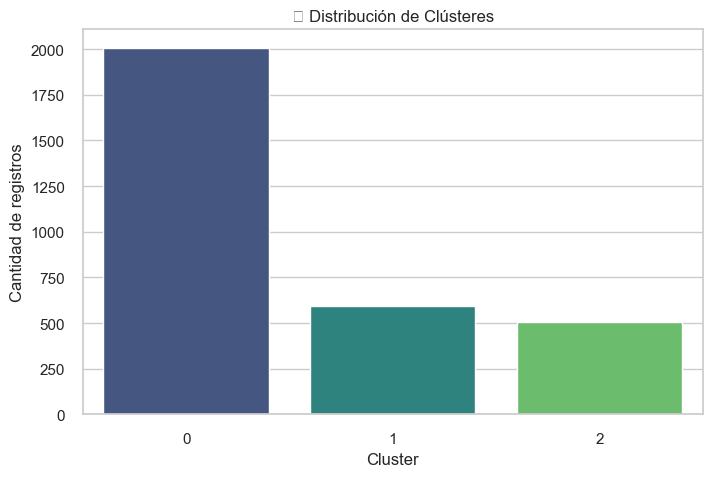

<Figure size 1200x600 with 0 Axes>

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


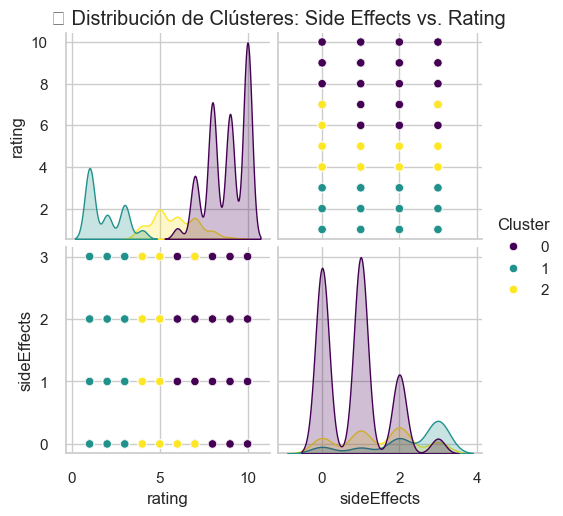

In [47]:

from sklearn.cluster import KMeans

# 📌 Cargar el dataset con clústeres asignados
file_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_clusters.tsv"  # Ajusta la ruta si es necesario
df_clusters = pd.read_csv(file_path, sep="\t")

# 🔹 Convertir 'rating' a numérico (si no lo es)
df_clusters["rating"] = pd.to_numeric(df_clusters["rating"], errors="coerce")

# 🔹 Convertir 'sideEffects' a valores numéricos (ejemplo: asignar valores representativos)
side_effects_mapping = {
    "No Side Effects": 0,
    "Mild Side Effects": 1,
    "Moderate Side Effects": 2,
    "Severe Side Effects": 3
}
df_clusters["sideEffects"] = df_clusters["sideEffects"].map(side_effects_mapping)

# 📊 Resumen estadístico por clúster
print("📊 Resumen estadístico por cluster:")
cluster_summary = df_clusters.groupby("Cluster").describe()
print(cluster_summary)

# 📊 Distribución de clústeres
plt.figure(figsize=(8, 5))
sns.countplot(x="Cluster", data=df_clusters, palette="viridis")
plt.title("📊 Distribución de Clústeres")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de registros")
plt.show()

# 🎨 Pairplot corregido
plt.figure(figsize=(12, 6))
sns.pairplot(df_clusters, vars=["rating", "sideEffects"], hue="Cluster", palette="viridis")
plt.suptitle("📊 Distribución de Clústeres: Side Effects vs. Rating", y=1.02)

# 📌 Mostrar el gráfico
plt.show()


### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.

In [44]:


# 📌 Cargar el dataset original
file_path_original = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_raw.tsv"
df = pd.read_csv(file_path_original, sep="\t")

# 🛑 Eliminar columnas innecesarias
columnas_a_eliminar = ["Unnamed: 0", "urlDrugName"]  # Ajusta si es necesario
df = df.drop(columns=columnas_a_eliminar, errors="ignore")

# 🚀 Guardar el dataset limpio para futuros ejercicios
cleaned_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_cleaned.tsv"
df.to_csv(cleaned_path, sep="\t", index=False)

print(f"✅ Dataset limpio guardado correctamente en: {cleaned_path}")



✅ Dataset limpio guardado correctamente en: C:\Users\hp\Desktop\Python Scripts\drugLibTrain_cleaned.tsv


✅ Clústeres asignados con K=4 y dataset guardado correctamente.
📊 Resumen estadístico por cluster:
         rating                                                 sideEffects  \
          count      mean       std  min  25%   50%   75%   max       count   
Cluster                                                                       
0         969.0  7.708978  0.583814  7.0  7.0   8.0   8.0   9.0       969.0   
1         391.0  1.915601  0.880290  1.0  1.0   2.0   3.0   3.0       391.0   
2        1154.0  9.640381  0.480097  9.0  9.0  10.0  10.0  10.0      1154.0   
3         418.0  5.119617  0.783553  4.0  4.0   5.0   6.0   6.0       418.0   

                                                      
             mean       std  min  25%  50%  75%  max  
Cluster                                               
0        1.249742  0.841561  0.0  1.0  1.0  2.0  3.0  
1        2.235294  1.018235  0.0  2.0  3.0  3.0  3.0  
2        0.489601  0.583359  0.0  0.0  0.0  1.0  3.0  
3        1.684211

C:\Users\hp\AppData\Local\Temp\ipykernel_12368\1511688623.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cluster", data=df, palette="viridis")
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


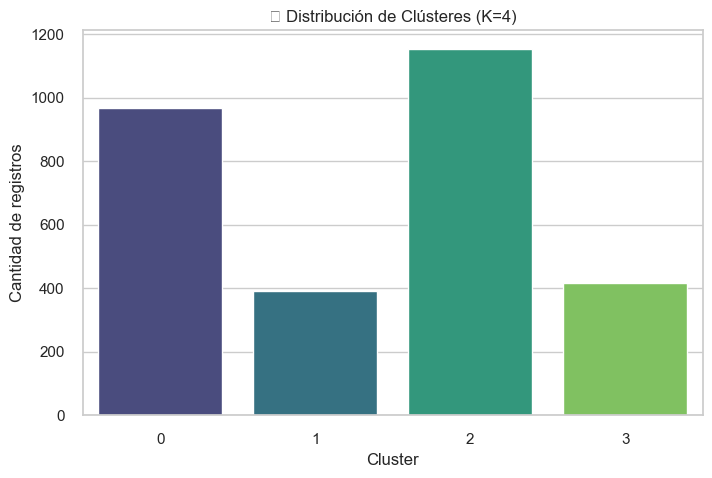

<Figure size 1200x600 with 0 Axes>

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


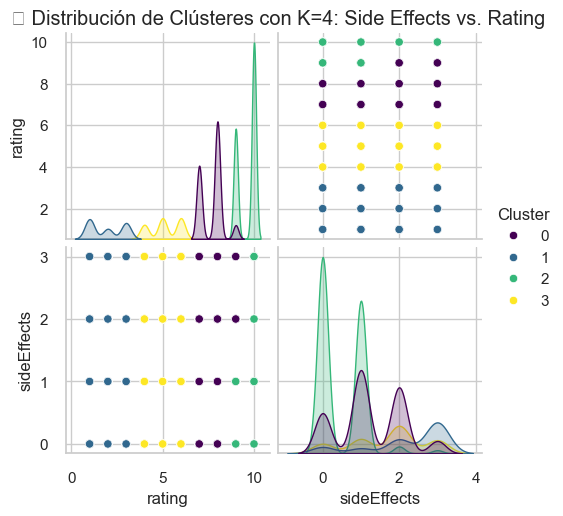

In [43]:


# 📌 Cargar el dataset original sin clústeres
file_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_cleaned.tsv"
df = pd.read_csv(file_path, sep="\t")

# 🔹 Convertir 'rating' a numérico (si no lo es)
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

# 🔹 Convertir 'sideEffects' a valores numéricos
side_effects_mapping = {
    "No Side Effects": 0,
    "Mild Side Effects": 1,
    "Moderate Side Effects": 2,
    "Severe Side Effects": 3
}
df["sideEffects"] = df["sideEffects"].map(side_effects_mapping)

# 🔹 Seleccionar variables para clustering y eliminar nulos
features = ["rating", "sideEffects"]
df = df.dropna(subset=features)  # Eliminar filas con valores nulos en las columnas relevantes
X = df[features].reset_index(drop=True)  # Resetear índices para asegurar alineación

# 📊 Aplicar K-Means con un nuevo K (ajusta el valor según el análisis previo)
nuevo_K = 4  # Cambia este valor si lo consideras necesario
kmeans = KMeans(n_clusters=nuevo_K, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

# 🔥 Guardar el dataset con el nuevo K
df.to_csv(r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_clusters_k4.tsv", sep="\t", index=False)
print(f"✅ Clústeres asignados con K={nuevo_K} y dataset guardado correctamente.")

# 📊 Resumen estadístico por clúster
print("📊 Resumen estadístico por cluster:")
cluster_summary = df.groupby("Cluster").describe()
print(cluster_summary)

# 📊 Distribución de clústeres
plt.figure(figsize=(8, 5))
sns.countplot(x="Cluster", data=df, palette="viridis")
plt.title(f"📊 Distribución de Clústeres (K={nuevo_K})")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de registros")
plt.show()

# 🎨 Pairplot para visualizar relación entre efectos secundarios y ratings con nuevo K
plt.figure(figsize=(12, 6))
sns.pairplot(df, vars=["rating", "sideEffects"], hue="Cluster", palette="viridis")
plt.suptitle(f"📊 Distribución de Clústeres con K={nuevo_K}: Side Effects vs. Rating", y=1.02)

# 📌 Mostrar el gráfico
plt.show()
